# Deep Learning - HW1

In [12]:
# Example code for reading the data and the initial weights and biases.
# Note: This is just an example of how to read these files, you can modify the code in your own implementation.

import numpy as np
import random
import matplotlib.pyplot as plt

train_x, train_y = np.load('train_x.npy'), np.load('train_y.npy')
test_x, test_y = np.load('test_x.npy'), np.load('test_y.npy')

print('shape of data:')
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


checkpoint = np.load('weights.npy', allow_pickle=True).item() #cheeckpoint為dict，w及b為key
init_weights = checkpoint['w']
init_biases = checkpoint['b']

print('shape of weights:')
for w in init_weights:    #init_weights:list(透過[0][1][2]取得參數)
    print(w.shape)
    

print()

print('shape of biases:')
for b in init_biases:
    print(b.shape)

shape of data:
(4500, 784)
(4500,)
(500, 784)
(500,)
shape of weights:
(784, 2048)
(2048, 512)
(512, 5)

shape of biases:
(2048,)
(512,)
(5,)


## Normalize image

In [14]:
train_x = train_x / 255
test_x = test_x / 255

## Define Function

In [15]:
def ReLU(x, deriv=False):
    if(deriv==True):
        return np.where(x > 0, 1, 0)   #where(condition,x,y)
    return np.maximum(0,x)

def softmax(x, deriv=False):
    if(deriv==True):
        s = softmax(x)
        return s * (1 - s)
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def cross_entropy(x, y):
    x = np.clip(x, 1e-15, 1 - 1e-15) # 限制 x 的範圍，避免計算 log 時出現零值
    x_log = [np.log(x[i][y[i]]) for i in range(len(y))] #[]找到index,label為1不用再乘
    loss = - np.sum(x_log) / len(y)
    return loss

def softmax_cross_entropy_deriv(y_pred, y_true):
    num_class = y_pred.shape[1]
    y_true = np.eye(num_class)[y_true]
    output_delta = y_pred - y_true
    return output_delta

## Create NN

In [16]:
class NeuralNetwork(object):
    def __init__(self,mode,drop_rate,shuffle=False,inputlayer=784,hiddenlayer1=2048,hiddenlayer2=512,outputlayer=5,lr=0.01):
        #parameter
        self.inputlayer=inputlayer
        self.hiddenlayer1=hiddenlayer1
        self.hiddenlayer2=hiddenlayer2
        self.outputlayer=outputlayer
        self.drop_rate=drop_rate
        self.shuffle=shuffle
        self.lr=lr
        #for plot
        self.iter=0
        self.trainlosslist=[]
        self.testlosslist=[]
        self.trainacclist=[]
        self.testacclist=[]
        #weight
        if mode == 'weight':
            self.w1=init_weights[0]
            self.w2=init_weights[1]
            self.w3=init_weights[2]
            self.b1=init_biases[0]
            self.b2=init_biases[1]
            self.b3=init_biases[2]

        elif mode == 'zero':
            self.w1=np.zeros((self.inputlayer,self.hiddenlayer1))
            self.w2=np.zeros((self.hiddenlayer1,self.hiddenlayer2))
            self.w3=np.zeros((self.hiddenlayer2,self.outputlayer))
            self.b1=np.zeros((self.hiddenlayer1))
            self.b2=np.zeros((self.hiddenlayer2))
            self.b3=np.zeros((self.outputlayer))

    def forward(self,x,drop_rate):
        self.z=np.dot(x,self.w1)+self.b1        #4500*2048
        self.a=ReLU(self.z)                     #through activation funtion
        mask1=np.random.binomial(1, 1 - drop_rate, self.a.shape)
        self.a*=mask1
        self.z2=np.dot(self.a,self.w2)+self.b2  #4500*512
        self.a2=ReLU(self.z2)
        mask2=np.random.binomial(1, 1 - drop_rate, self.a2.shape)
        self.a2*=mask2
        self.z3=np.dot(self.a2,self.w3)+self.b3 #4500*5
        output=softmax(self.z3)
        return output

    def backward(self,x,output,y_true):      #backward propagate through the network
        self.output_delta=softmax_cross_entropy_deriv(output,y_true) #200*5

        self.z3_error=self.output_delta.dot(self.w3.T)               #200*512
        self.z3_delta=self.z3_error*ReLU(self.a2,deriv=True)         #200*512
        self.z2_error=self.z3_delta.dot(self.w2.T)                   #200*2048
        self.z2_delta=self.z2_error*ReLU(self.a,deriv=True)          #200*2048
        #更新網路參數
        self.w3 -= (np.dot(self.a2.T,self.output_delta)/self.a2.T.shape[0])*self.lr
        self.w2 -= (np.dot(self.a.T,self.z3_delta)/self.a.T.shape[0])*self.lr
        self.w1 -= (np.dot(x.T,self.z2_delta)/x.T.shape[0])*self.lr
        self.b3 -= (np.mean(self.output_delta,axis=0))*self.lr
        self.b2 -= (np.mean(self.z3_delta,axis=0))*self.lr
        self.b1 -= (np.mean(self.z2_delta,axis=0))*self.lr
        
    def train(self, x, y, batch_size):
        num_batches = int(np.ceil(x.shape[0] / batch_size)) #ceil向上取整數
        for batch in range(num_batches):
            batch_start = batch * batch_size
            batch_end = min(batch_start + batch_size, x.shape[0])
            x_batch = x[batch_start:batch_end, :]
            y_batch = y[batch_start:batch_end,]

            if self.shuffle == True: #random.shuffle後的資料有誤，選擇用np.random.shuffle
                np.random.seed(42)    
                np.random.shuffle(x_batch)
                np.random.seed(42)         
                np.random.shuffle(y_batch)

            y_pred = self.forward(x_batch,self.drop_rate)
            self.backward(x_batch,y_pred,y_batch)
            
            self.iter += 1

            if self.iter % 25 == 0 or self.iter == 690:  #每個epoch執行23iterations，30epochs共690iterations
                #紀錄train,test的loss
                train_loss = cross_entropy(self.forward(train_x,self.drop_rate),train_y)
                self.trainlosslist.append(train_loss)
                print(f'Iteration: {self.iter}: train loss: {train_loss:.4f}')
                
                test_loss = cross_entropy(self.forward(test_x,0),test_y)   #測試時將dropout關閉
                self.testlosslist.append(test_loss)
                print(f'Iteration: {self.iter}: test loss: {test_loss:.4f}')
                
                #紀錄train,test的accuracy
                train_pred = np.argmax(self.forward(train_x,self.drop_rate), axis=1)
                train_acc = np.sum(train_pred == train_y) / train_y.shape[0]
                self.trainacclist.append(train_acc)
                print(f'Iteration: {self.iter} train accuracy: {train_acc:.4f}')
                
                test_pred = np.argmax(self.forward(test_x,0), axis=1)     #測試時將dropout關閉
                test_acc = np.sum(test_pred == test_y) / test_y.shape[0]
                self.testacclist.append(test_acc)
                print(f'Iteration: {self.iter} test accuracy: {test_acc:.4f}')
            
    
    def getweight(self):
        return self.w1,self.w2,self.w3,self.b1,self.b2,self.b3

### 1(a) Plot the learning curves and the accuracy(every 25 iterations)

epoch: 0 loss:26.9503
epoch: 1 loss:14.9087
Iteration: 25: train loss: 14.8167
Iteration: 25: test loss: 17.7186
Iteration: 25 train accuracy: 0.5576
Iteration: 25 test accuracy: 0.4780
epoch: 2 loss:12.7196
Iteration: 50: train loss: 11.3060
Iteration: 50: test loss: 15.1429
Iteration: 50 train accuracy: 0.6564
Iteration: 50 test accuracy: 0.5460
epoch: 3 loss:12.1259
Iteration: 75: train loss: 9.6597
Iteration: 75: test loss: 14.5377
Iteration: 75 train accuracy: 0.7049
Iteration: 75 test accuracy: 0.5660
epoch: 4 loss:10.9933
Iteration: 100: train loss: 9.0405
Iteration: 100: test loss: 13.7340
Iteration: 100 train accuracy: 0.7231
Iteration: 100 test accuracy: 0.5880
epoch: 5 loss:10.1079
Iteration: 125: train loss: 9.1151
Iteration: 125: test loss: 13.3304
Iteration: 125 train accuracy: 0.7140
Iteration: 125 test accuracy: 0.5960
epoch: 6 loss:9.0309
Iteration: 150: train loss: 8.5502
Iteration: 150: test loss: 13.1204
Iteration: 150 train accuracy: 0.7356
Iteration: 150 test accu

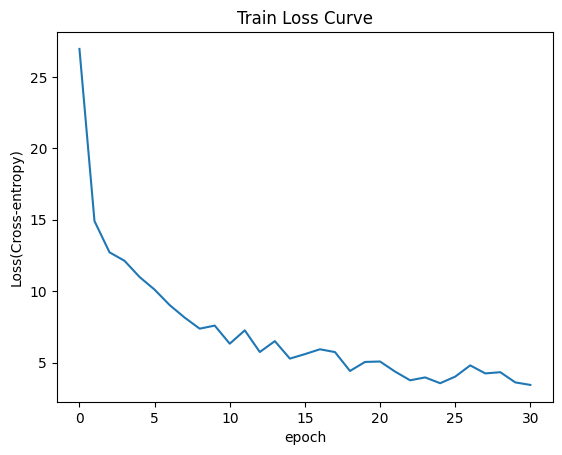

In [17]:
model1a=NeuralNetwork(mode='weight',drop_rate=0,inputlayer=784,hiddenlayer1=2048,hiddenlayer2=512,outputlayer=5,lr=0.01)

def train_and_plot_loss(epochs,model,x,y): #設定訓練過程
    error_list=[]
    error_list.append(cross_entropy(model.forward(x,model.drop_rate),y))
    print('epoch:',0,'loss:%.4f' %error_list[0])
    for i in range(epochs):
        model.train(x,y,200)
        error_list.append(cross_entropy(model.forward(x,model.drop_rate),y))
        print('epoch:',i+1,'loss:%.4f' %error_list[i+1])
    
    fig, ax = plt.subplots()
    ax.plot(np.arange((len(error_list))),error_list)
    ax.set_title('Train Loss Curve')
    plt.xlabel('epoch')
    plt.ylabel('Loss(Cross-entropy)')
    plt.show()
    
train_and_plot_loss(30,model1a,train_x,train_y)

In [18]:
def result(x):  #劃出loss及accuracy曲線
    print("The Final Train Loss:%.4f" %x.trainlosslist[-1])
    print("The Final Test Loss:%.4f" %x.testlosslist[-1])
    print("The Final Train Accuracy:%.4f" %x.trainacclist[-1])
    print("The Final Test Accuracy:%.4f" %x.testacclist[-1])
    step = list(range(25, 690, 25)) + [690]
    # fig, ax = plt.subplots()
    plt.subplot(1,2,1)
    plt.plot(step,x.trainlosslist,label='train')
    plt.plot(step,x.testlosslist,label='test')
    plt.title('Loss Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.plot(step,x.trainacclist,label='train')
    plt.plot(step,x.testacclist,label='test')
    plt.title('Accuracy Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.tight_layout() #保持子圖距離
    plt.show()

The Final Train Loss:3.4421
The Final Test Loss:9.1869
The Final Train Accuracy:0.8767
The Final Test Accuracy:0.7040


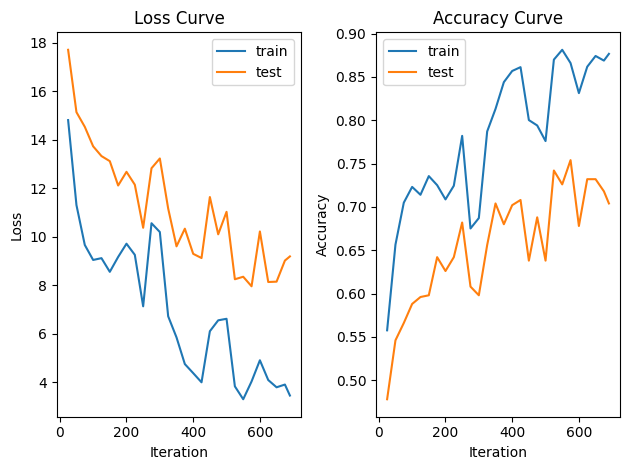

In [19]:
result(model1a)

### 1(b) Considering zero initialization for the model weights

epoch: 0 loss:1.6094
epoch: 1 loss:1.6094
Iteration: 25: train loss: 1.6094
Iteration: 25: test loss: 1.6094
Iteration: 25 train accuracy: 0.2000
Iteration: 25 test accuracy: 0.2000
epoch: 2 loss:1.6094
Iteration: 50: train loss: 1.6094
Iteration: 50: test loss: 1.6094
Iteration: 50 train accuracy: 0.2000
Iteration: 50 test accuracy: 0.2000
epoch: 3 loss:1.6094
Iteration: 75: train loss: 1.6094
Iteration: 75: test loss: 1.6094
Iteration: 75 train accuracy: 0.2000
Iteration: 75 test accuracy: 0.2000
epoch: 4 loss:1.6094
Iteration: 100: train loss: 1.6094
Iteration: 100: test loss: 1.6094
Iteration: 100 train accuracy: 0.2000
Iteration: 100 test accuracy: 0.2000
epoch: 5 loss:1.6094
Iteration: 125: train loss: 1.6094
Iteration: 125: test loss: 1.6094
Iteration: 125 train accuracy: 0.2000
Iteration: 125 test accuracy: 0.2000
epoch: 6 loss:1.6094
Iteration: 150: train loss: 1.6094
Iteration: 150: test loss: 1.6094
Iteration: 150 train accuracy: 0.2000
Iteration: 150 test accuracy: 0.2000
e

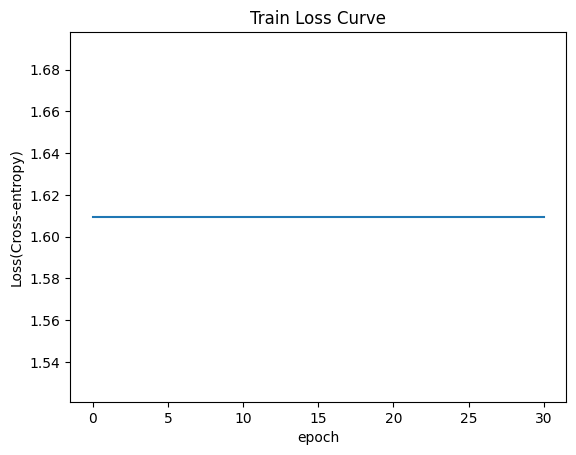

In [20]:
model1b=NeuralNetwork(mode='zero',drop_rate=0,inputlayer=784,hiddenlayer1=2048,hiddenlayer2=512,outputlayer=5,lr=0.01)
train_and_plot_loss(30,model1b,train_x,train_y)

The Final Train Loss:1.6094
The Final Test Loss:1.6094
The Final Train Accuracy:0.2000
The Final Test Accuracy:0.2000


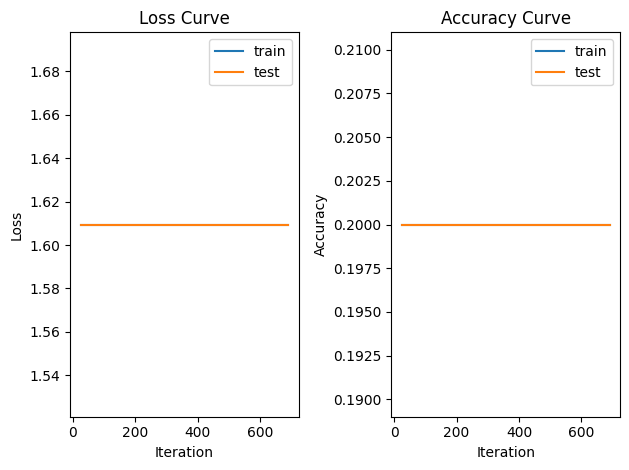

In [21]:
result(model1b)

討論:由於模型的初始參數皆為0，在第一次輸出時皆為零，每個參數的梯度也都為0，在倒傳遞時無法有效地更新參數，所以loss及accuracy曲線在訓練時也都沒有變化。

### 2(a) Implement the dropout layers

epoch: 0 loss:16.1908
epoch: 1 loss:14.2026
Iteration: 25: train loss: 13.5945
Iteration: 25: test loss: 8.7167
Iteration: 25 train accuracy: 0.5753
Iteration: 25 test accuracy: 0.7340
epoch: 2 loss:12.8421
Iteration: 50: train loss: 12.5332
Iteration: 50: test loss: 9.6018
Iteration: 50 train accuracy: 0.5949
Iteration: 50 test accuracy: 0.7080
epoch: 3 loss:12.7512
Iteration: 75: train loss: 11.7596
Iteration: 75: test loss: 9.6256
Iteration: 75 train accuracy: 0.6411
Iteration: 75 test accuracy: 0.7120
epoch: 4 loss:11.7564
Iteration: 100: train loss: 11.5309
Iteration: 100: test loss: 9.7755
Iteration: 100 train accuracy: 0.6418
Iteration: 100 test accuracy: 0.7040
epoch: 5 loss:11.1706
Iteration: 125: train loss: 10.7148
Iteration: 125: test loss: 9.3019
Iteration: 125 train accuracy: 0.6698
Iteration: 125 test accuracy: 0.7080
epoch: 6 loss:10.9358
Iteration: 150: train loss: 10.9010
Iteration: 150: test loss: 8.6539
Iteration: 150 train accuracy: 0.6536
Iteration: 150 test accur

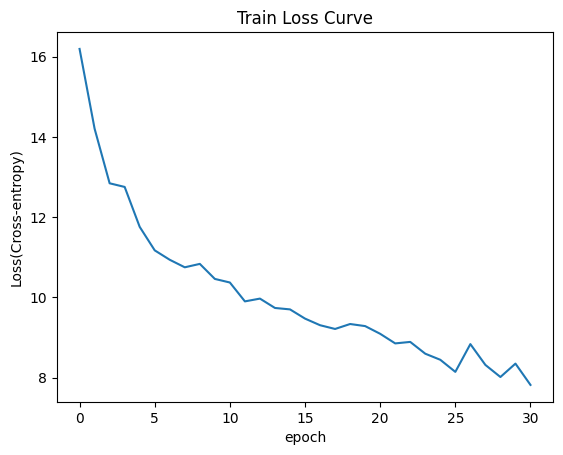

In [22]:
model2a=NeuralNetwork(mode='weight',drop_rate=0.2,inputlayer=784,hiddenlayer1=2048,hiddenlayer2=512,outputlayer=5,lr=0.01)
train_and_plot_loss(30,model2a,train_x,train_y)

The Final Train Loss:7.7782
The Final Test Loss:7.1078
The Final Train Accuracy:0.7331
The Final Test Accuracy:0.7720


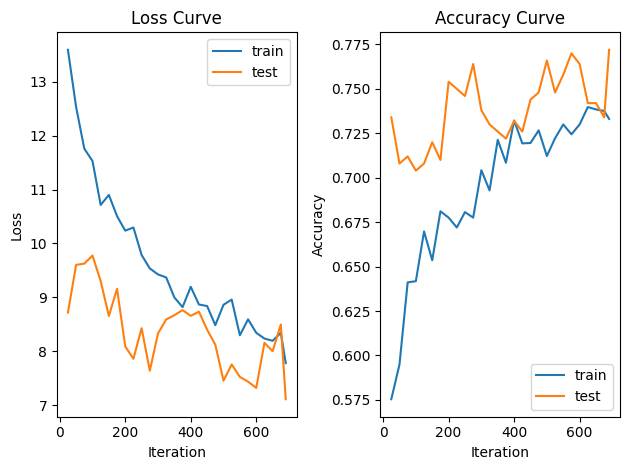

In [23]:
result(model2a)

討論:
Dropout是一種用於神經網絡的正則化技術，可防止過擬合。在訓練期間，Dropout會隨機將層中的一部分神經元丟棄（置零），從而為每次的訓練創建一個新的稀疏網絡，想藉此提高網路的泛化能力。
相比model1(a)，使用dropout後的model2(a)在train的loss上升accuracy下降，但在test的loss下降accuracy上升，也證明dropout能提高網路泛化能力。

### 3(a) Reshuffle the data in every batch

epoch: 0 loss:3.4521
epoch: 1 loss:2.7725
Iteration: 25: train loss: 2.7582
Iteration: 25: test loss: 6.5499
Iteration: 25 train accuracy: 0.9004
Iteration: 25 test accuracy: 0.7860
epoch: 2 loss:2.6051
Iteration: 50: train loss: 2.5963
Iteration: 50: test loss: 6.5430
Iteration: 50 train accuracy: 0.9042
Iteration: 50 test accuracy: 0.7800
epoch: 3 loss:2.4367
Iteration: 75: train loss: 2.4645
Iteration: 75: test loss: 6.2185
Iteration: 75 train accuracy: 0.9091
Iteration: 75 test accuracy: 0.7900
epoch: 4 loss:2.3361
Iteration: 100: train loss: 2.5142
Iteration: 100: test loss: 6.4490
Iteration: 100 train accuracy: 0.9051
Iteration: 100 test accuracy: 0.7740
epoch: 5 loss:2.1641
Iteration: 125: train loss: 2.0881
Iteration: 125: test loss: 5.8071
Iteration: 125 train accuracy: 0.9138
Iteration: 125 test accuracy: 0.8100
epoch: 6 loss:2.1294
Iteration: 150: train loss: 1.9068
Iteration: 150: test loss: 5.6873
Iteration: 150 train accuracy: 0.9209
Iteration: 150 test accuracy: 0.8060
e

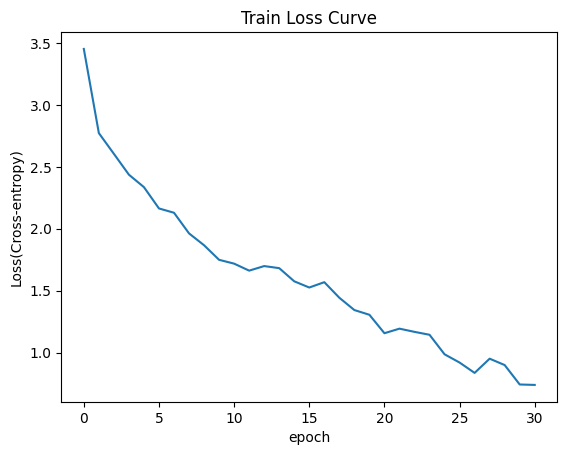

In [24]:
model3a=NeuralNetwork(mode='weight',shuffle=True,drop_rate=0,inputlayer=784,hiddenlayer1=2048,hiddenlayer2=512,outputlayer=5,lr=0.01)
train_and_plot_loss(30,model3a,train_x,train_y)

The Final Train Loss:0.7393
The Final Test Loss:5.0501
The Final Train Accuracy:0.9504
The Final Test Accuracy:0.8140


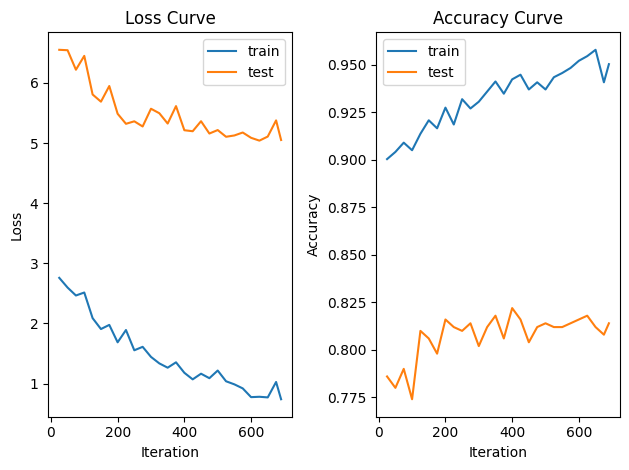

In [25]:
result(model3a)

討論:在模型3(a)中，在每個batch裡面shuffle資料，shuffle是指在訓練過程中將訓練數據隨機打亂的過程，其目的是防止模型過度擬合訓練數據的順序。如果模型在訓練過程中總是接收相同的訓練數據，它可能會過度適應這些數據，從而失去對新數據的泛化能力。
就結果來看，在test的部分，表現出比前面幾組模型更好的結果，也證明了shuffle的重要性。